### Set environment for CUDA and theano packages, add local python packages dir and data dir

In [2]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3
%env THEANO_FLAGS=device=cuda1,floatX=float32,gpuarray.preallocate=0.45
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")
DIR_NAME = "/home/shirobokov/data/news_pickles"

env: CUDA_VISIBLE_DEVICES=0,1,2,3
env: THEANO_FLAGS=device=cuda1,floatX=float32,gpuarray.preallocate=0.45
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

Using cuDNN version 5110 on context None
Preallocating 5147/11439 Mb (0.450000) on cuda1
Mapped name None to device cuda1: Tesla K80 (597E:00:00.0)


# Read data and transfer it to numpy array

In [5]:
from tqdm import tqdm
from collections import defaultdict
import os
import numpy as np

import dill

path = "dust_fog.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    dust = pickle.load(f)
    
path = "C80keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c80 = pickle.load(f)
    
path = "C60keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c60 = pickle.load(f)
    
path = "C100keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c100 = pickle.load(f)    
    
path = "gamma.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    gamma = pickle.load(f)

In [6]:
from tqdm import tqdm
from collections import defaultdict
import os
import numpy as np

import dill

path = "dust_fog.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    dust_fog_numpy = np.array(list(dill.load(f).values()))
    
path = "C80keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c80_numpy = np.array(list(dill.load(f).values()))
    
path = "C60keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c60_numpy = np.array(list(dill.load(f).values()))
    
path = "C100keV.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    c100_numpy = np.array(list(dill.load(f).values()))    
    
path = "gamma.dill"
with open(os.path.join(DIR_NAME, path), 'rb') as f:
    gamma_numpy = np.array(list(dill.load(f).values()))

In [8]:
print (c60_numpy.shape)
print (c80_numpy.shape)
print (c100_numpy.shape)
print (dust_fog_numpy.shape)
print (gamma_numpy.shape)

(45592, 8, 30, 30)
(68066, 8, 30, 30)
(43333, 8, 30, 30)
(65866, 8, 30, 30)
(61082, 8, 30, 30)


# Make train/validation/test split functions

### Important, do NOT shuffle data, as crops could be repeated X time(X is about 10)*

#### *ocenka metodom pristalnogo vzglada

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.model_selection import train_test_split
def split_data(data, train_split=0.8, validation_split=0.1, test_split=0.1, signal=0):
    answers = np.ones(data.shape[0]) * signal
    X_train, X_test_val, y_train, y_test_val = train_test_split(data, answers, train_size=train_split, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val,
                                                                train_size=(validation_split / (1 - train_split)),
                                                                shuffle=False)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def prepare_data(signal, dust, gamma):
    '''Provided intact blocks of data, we now shuffle them whithin each other'''
    data = {}
    keys = (("X_train", "y_train"), ("X_val", "y_val"), ("X_test", "y_test"))
    
    signal = split_data(signal, signal=1)
    dust = split_data(dust, signal=0)
    gamma = split_data(gamma, signal=2)
    
    
    for pair_signal, pair_dust, pair_gamma, key in zip(signal, dust, gamma, keys):
        data[key[0]], data[key[1]] = np.vstack((pair_signal[0], pair_dust[0], pair_gamma[0])),\
                          np.hstack((pair_signal[1], pair_dust[1], pair_gamma[1]))
        shuffle_ind = np.random.choice(range(data[key[0]].shape[0]), size = data[key[0]].shape[0], replace=False)
        data[key[0]] = data[key[0]][shuffle_ind]
        data[key[1]] = data[key[1]][shuffle_ind]
    return data

### Load the network

### This is a VGG like structure taken, with additional  dropout layers in the middle and in the end to prevent overfitting/accuray results

In [76]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import *
from lasagne.nonlinearities import softmax

def build_my_net():
    net = {}
    net['input'] = InputLayer((None, 8, 30, 30))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_1'], 2)
    
    net['drop_middle'] = DropoutLayer(net['pool2'],p=0.5)
    
    net['conv3_1'] = ConvLayer(
        net['drop_middle'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_1'], 2)
    
    net['conv4_1'] = ConvLayer(
        net['pool3'], 256, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_1'], 2)    
    
    net['drop'] = DropoutLayer(net['pool4'],p=0.5)
    net['fc'] = DenseLayer(net['pool4'], num_units=3, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc'], softmax)

    return net

In [78]:
netus = build_my_net()

In [79]:
get_all_layers(netus)

['input',
 'conv1_1',
 'conv1_2',
 'pool1',
 'conv2_1',
 'pool2',
 'drop_middle',
 'conv3_1',
 'pool3',
 'conv4_1',
 'pool4',
 'drop',
 'fc',
 'prob']

### The ouput shape is N samples X 3 - probability of each class for each crop

In [80]:
get_output_shape(netus['prob'])

(None, 3)

In [82]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [83]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

def scoring_function(score_fun, y_true, y_pred, threshold=0.5):
    if threshold is None:
        return score_fun(y_true, np.asarray(y_pred))
    else:
        return score_fun(y_true, np.argmax(np.array(y_pred), axis=1))

In [84]:
from IPython import display
import time
from pandas import ewma

In [96]:
def train_on_data(X_train, y_train, X_test, y_test, num_epochs=200,
                  warm_start=False, loss_history=None, saved_weights=None, val_loss=None, lr=1e-6,
                  batch_size=1024):
    if not warm_start:
        loss_history = []
        val_loss = []

    # TODO Better to set this as input parameters
    net = build_my_net()
    input_image = T.tensor4('input')
    NECK = 'prob'

    net_head = net[NECK]

    output = get_output(net_head, input_image)
    output_det = get_output(net_head, input_image, deterministic=True)
    
    reference_answers = T.ivector('reference answers')

    loss = T.nnet.categorical_crossentropy(output, reference_answers).mean()

    if warm_start:
        set_all_param_values(net_head, saved_weights)
    
    weights = get_all_params(net_head, trainable=True)
    
    updates = lasagne.updates.adam(loss, weights, learning_rate=lr)

    accuracy = lasagne.objectives.categorical_accuracy(output_det, reference_answers).mean()

    train = theano.function([input_image, reference_answers], [loss, accuracy],
                                            updates=updates, allow_input_downcast=True)

    predict = theano.function([input_image], output_det, allow_input_downcast=True)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()

        for batch in tqdm(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
            train_err_batch, train_acc_batch= train(*batch)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # Predict on test
        y_pred = []
        for batch in tqdm(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
            x_batch , y_batch = batch
            y_pred.extend(list(predict(x_batch)))
        threshold=0.5
        val_acc = scoring_function(accuracy_score, y_test, y_pred, threshold)
        val_loss.append(scoring_function(log_loss, y_test, y_pred, threshold=None))
        loss_history.append(val_acc)
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Val acc for ")
        plt.xlabel("#iteration")
        plt.ylabel("acc")
        plt.plot(loss_history, 'b',label='val acc')
        plt.plot(ewma(np.array(loss_history),span=10),'r',label='ewm val acc')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc * 100))
        
        print("  validation loss:\t\t{:.6f}".format(
            val_loss[-1]))        
    weights_to_save = [w.get_value() for w in get_all_params(net_head)]
    return net_head, weights_to_save, loss_history, (val_acc, val_loss)

In [105]:
def predict(weights, X_test, batch_size=128):
    input_image = T.tensor4('input')
    
    # TODO Better to set this as input parameters
    net = build_my_net()
    NECK = 'prob'
    net_head = net[NECK]
    
    output_det = get_output(net_head, input_image, deterministic=True)
    set_all_param_values(net_head, weights)
    predict = theano.function([input_image], output_det, allow_input_downcast=True)
    
    y_pred = []
    for batch in tqdm(iterate_minibatches(X_test, range(X_test.shape[0]), batch_size, shuffle=False)):
        x_batch , y_batch = batch
        y_pred.extend(list(predict(x_batch)))
    return y_pred

## Randomly Subsample from c to get equal proportion of classes

In [63]:
np.random.seed(1543)
signal = np.vstack((c60_numpy[np.random.choice(c60_numpy.shape[0], size = 21152)],
                    c80_numpy[np.random.choice(c80_numpy.shape[0], size = 22342)],
                    c100_numpy[np.random.choice(c100_numpy.shape[0], size = 21711)]))

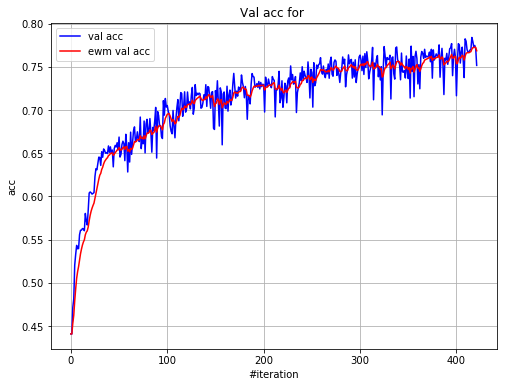

0it [00:00, ?it/s]

Epoch 422 of 600 took 107.898s
  training loss (in-iteration):		0.310355
  train accuracy:		91.09 %
  validation accuracy:		75.17 %
  validation loss:		0.636155


108it [01:14,  1.44it/s]

In [ ]:
my_dict = prepare_data(signal, dust_fog_numpy, gamma_numpy)
resulted_net = train_on_data(my_dict["X_train"], my_dict["y_train"], my_dict["X_val"], my_dict["y_val"],
                             num_epochs=600, lr=1e-5)

### Use warm start to train net from given point, since we saved wights

In [158]:
results_new = train_on_data(my_dict["X_train"], my_dict["y_train"], my_dict["X_val"], my_dict["y_val"],
              num_epochs=600, warm_start=True, loss_history=resulted_net[1], saved_weights=resulted_net[0], lr=1e-6)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  import sys


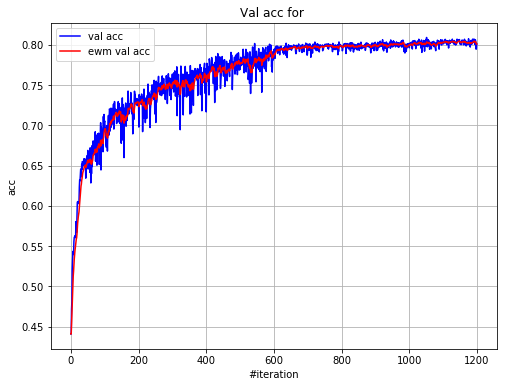

In [121]:
plt.figure(figsize=(8, 6))

plt.title("Val acc for ")
plt.xlabel("#iteration")
plt.ylabel("acc")
plt.plot(results_new[2], 'b',label='val acc')
plt.plot(ewma(np.array(results_new[2]),span=10),'r',label='ewm val acc')
plt.legend(loc='best')
plt.grid()
plt.show()

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  import sys


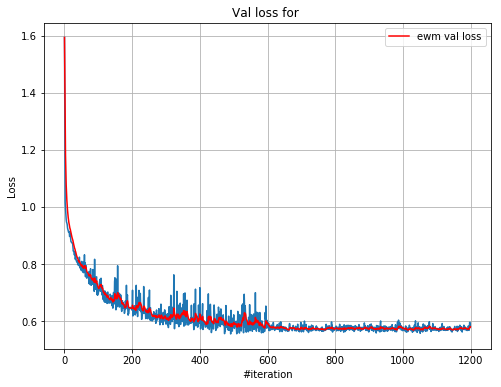

In [124]:
plt.figure(figsize=(8, 6))

plt.title("Val loss for ")
plt.xlabel("#iteration")
plt.ylabel("Loss")
plt.plot(results_new[3][1])
plt.plot(ewma(np.array(results_new[3][1]),span=10),'r',label='ewm val loss')
plt.legend(loc='best')
plt.grid()
plt.show()

## plot crops

In [186]:
dust_fog_numpy.shape

(65866, 8, 30, 30)

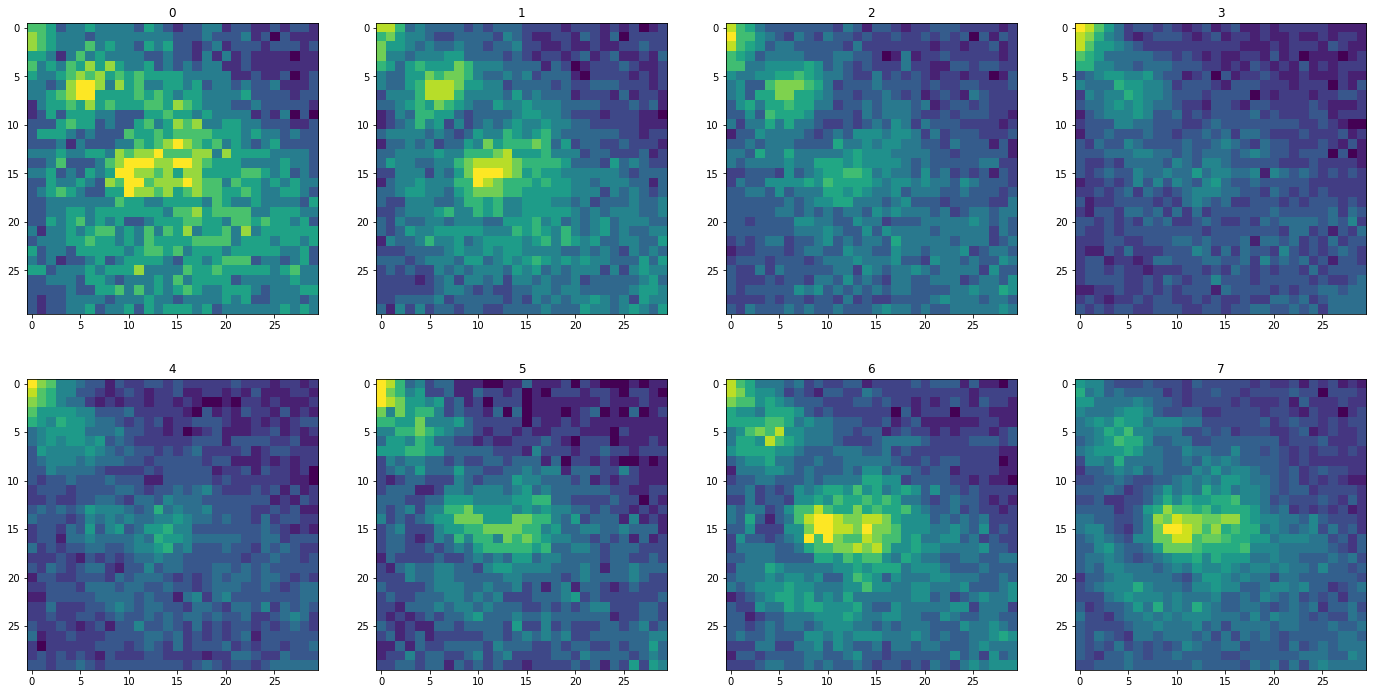

In [236]:
f, axes = plt.subplots(2, 4,figsize=(24, 12))

view = np.random.randint(gamma_numpy.shape[0])


for key, ax in zip(range(8), axes.ravel()):
    
    ax.imshow(gamma_numpy[view, key, : ,:])
    ax.set_title(key)
plt.plot()
plt.savefig("gamma_views.pdf")